# 7. Review Features: Playtime

## Setup

In [2]:
import ast
import nltk
import numpy as np
import pandas as pd
import re
from sklearn.dummy import DummyRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.svm import LinearSVR

In [3]:
nltk.download('stopwords')
from nltk.corpus import stopwords
languages = [
    'arabic', 'azerbaijani', 'bengali', 'danish', 'dutch', 'english',
    'finnish', 'french', 'german', 'greek', 'hungarian', 'indonesian',
    'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian',
    'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish'
]
english_stopwords = set(stopwords.words('english'))
all_stopwords = set()
for language in languages:
    all_stopwords |= set(stopwords.words(language))

[nltk_data] Downloading package stopwords to C:\Users\Conor Mac
[nltk_data]     Amhlaoibh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
DIR_SAMPLE = '../data/samples/'
PATH_SAMPLES = DIR_SAMPLE + 'review_sentiment/%s.csv'
DIR_RESULT = '../data/results/bert/'
PATH_RESULTS_HP = DIR_RESULT + 'review_playtime/hyperparams/eng_any_any_100000_%d_train.txt'
PATH_RESULTS_OPT = DIR_RESULT + 'review_playtime/optimal/%s_10_%s.txt'

## Data Reading and Writing

In [5]:
def preprocess_text(text, is_english=True):
    if is_english:
        text = text.lower()
        stopword_list = english_stopwords
    else:
        stopword_list = all_stopwords
    text = re.sub(r'[^\w\s]', ' ', text, re.UNICODE)
    text = ' '.join([
        word
        for word in text.split()
        if word not in stopword_list
    ])
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [7]:
def read_data(sample_name, train_size=0.9, seed=None):
    df = pd.read_csv(PATH_SAMPLES % sample_name)[['pt_review', 'text']].reset_index(drop=True)
    if sample_name.startswith('eng'):
        df['text'] = df['text'].apply(lambda text: preprocess_text(text, is_english=True))
    else:
        df['text'] = df['text'].apply(lambda text: preprocess_text(text, is_english=False))
    scaler = RobustScaler()
    df['pt_review_scaled'] = scaler.fit_transform(np.array(df['pt_review']).reshape(-1, 1))
    train, validation = train_test_split(df, train_size=train_size, random_state=seed)
    return train, validation

## Hyperparameter Tuning

In [8]:
sample_name = 'eng_any_any_100000'
seed = 1337
train, validation = read_data(sample_name, seed=seed)
Xt, Yt = train['text'].tolist(), train['pt_review_scaled'].tolist()
Xv, Yv = validation['text'].tolist(), validation['pt_review_scaled'].tolist()

In [9]:
# fit TFIDF models first
ngram_ranges = [(1, 2), (1, 3), (1, 4)]
Xt_tfidfs, Xv_tfidfs = [], []
for ngram_range in ngram_ranges:
    tfidf = TfidfVectorizer(ngram_range=ngram_range, binary=True, smooth_idf=False)
    Xt_tfidfs.append(tfidf.fit_transform(Xt))
    Xv_tfidfs.append(tfidf.transform(Xv))

In [10]:
results = {}

In [11]:
results['bl'] = {}
bl_mean = DummyRegressor(strategy='mean')
scores = cross_val_score(bl_mean, Xt, Yt, scoring='neg_mean_squared_error', cv=5)
mean, std = round(scores.mean(), 4), round(scores.std(), 4)
results['bl']['mean'] = (mean, std)
bl_const = DummyRegressor(strategy='median')
scores = cross_val_score(bl_const, Xt, Yt, scoring='neg_mean_squared_error', cv=5)
mean, std = round(scores.mean(), 4), round(scores.std(), 4)
results['bl']['median'] = (mean, std)

In [12]:
for i, ngram_range in enumerate(ngram_ranges):
    print(f'=== TFIDF: ngram_range=(1,{ngram_range[1]}) ===')
    Xt_tfidf = Xt_tfidfs[i]
    Xv_tfidf = Xv_tfidfs[i]
    results[ngram_range] = {}
    # SGDRegressor
    alphas = [0.001, 0.0001, 0.00001, 0.000001]
    results[ngram_range]['sgd'] = {}
    for alpha in alphas:
        print(f'>>> SGDRegressor (alpha={alpha}) <<<')
        model = SGDRegressor(penalty='l2', alpha=alpha, max_iter=1000)
        scores = cross_val_score(model, Xt_tfidf, Yt, scoring='neg_mean_squared_error', cv=5)
        mean, std = round(scores.mean(), 4), round(scores.std(), 4)
        print(f'mean={mean}, std={std}')
        results[ngram_range]['sgd'][alpha] = (mean, std)
    # Ridge
    alphas = [0.01, 0.1, 1, 10]
    results[ngram_range]['ridge'] = {}
    for alpha in alphas:
        print(f'>>> Ridge (alpha={alpha}) <<<')
        model = Ridge(alpha=alpha)
        scores = cross_val_score(model, Xt_tfidf, Yt, scoring='neg_mean_squared_error', cv=5)
        mean, std = round(scores.mean(), 4), round(scores.std(), 4)
        print(f'mean={mean}, std={std}')
        results[ngram_range]['ridge'][alpha] = (mean, std)
    # LinearSVR
    Cs = [0.01, 0.1, 1, 10]
    results[ngram_range]['lsvr'] = {}
    for C in Cs:
        print(f'>>> LinearSVR (C={C}) <<<')
        model = LinearSVR(C=C, max_iter=1000)
        scores = cross_val_score(model, Xt_tfidf, Yt, scoring='neg_mean_squared_error', cv=5)
        mean, std = round(scores.mean(), 4), round(scores.std(), 4)
        print(f'mean={mean}, std={std}')
        results[ngram_range]['lsvr'][C] = (mean, std)

=== TFIDF: ngram_range=(1,2) ===
>>> SGDRegressor (alpha=0.001) <<<
mean=-47.2423, std=5.6547
>>> SGDRegressor (alpha=0.0001) <<<


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: Convergence

mean=-45.6209, std=5.6111
>>> SGDRegressor (alpha=1e-05) <<<


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: Convergence

mean=-45.452, std=5.6204
>>> SGDRegressor (alpha=1e-06) <<<


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: Convergence

mean=-45.4503, std=5.6224
>>> Ridge (alpha=0.01) <<<
mean=-58.0063, std=4.9918
>>> Ridge (alpha=0.1) <<<
mean=-51.9621, std=5.1765
>>> Ridge (alpha=1) <<<
mean=-46.5621, std=5.5564
>>> Ridge (alpha=10) <<<
mean=-45.6807, std=5.6138
>>> LinearSVR (C=0.01) <<<
mean=-52.5595, std=5.8765
>>> LinearSVR (C=0.1) <<<
mean=-51.6864, std=5.8516
>>> LinearSVR (C=1) <<<
mean=-49.755, std=5.8187
>>> LinearSVR (C=10) <<<
mean=-47.2056, std=5.6805
=== TFIDF: ngram_range=(1,3) ===
>>> SGDRegressor (alpha=0.001) <<<
mean=-47.6953, std=5.6684
>>> SGDRegressor (alpha=0.0001) <<<


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: Convergence

mean=-46.0365, std=5.6365
>>> SGDRegressor (alpha=1e-05) <<<


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: Convergence

mean=-45.7222, std=5.6465
>>> SGDRegressor (alpha=1e-06) <<<


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: Convergence

mean=-45.6989, std=5.6482
>>> Ridge (alpha=0.01) <<<
mean=-50.9226, std=5.3479
>>> Ridge (alpha=0.1) <<<
mean=-49.1302, std=5.4266
>>> Ridge (alpha=1) <<<
mean=-46.2043, std=5.6111
>>> Ridge (alpha=10) <<<
mean=-46.1031, std=5.6389
>>> LinearSVR (C=0.01) <<<
mean=-52.6507, std=5.8783
>>> LinearSVR (C=0.1) <<<
mean=-51.8914, std=5.8533
>>> LinearSVR (C=1) <<<
mean=-49.9108, std=5.8264
>>> LinearSVR (C=10) <<<
mean=-46.9667, std=5.7133
=== TFIDF: ngram_range=(1,4) ===
>>> SGDRegressor (alpha=0.001) <<<
mean=-47.8871, std=5.677
>>> SGDRegressor (alpha=0.0001) <<<


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: Convergence

mean=-46.3251, std=5.6493
>>> SGDRegressor (alpha=1e-05) <<<


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: Convergence

mean=-45.9729, std=5.6618
>>> SGDRegressor (alpha=1e-06) <<<


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: Convergence

mean=-45.9424, std=5.6642
>>> Ridge (alpha=0.01) <<<
mean=-49.6923, std=5.5502
>>> Ridge (alpha=0.1) <<<
mean=-48.4684, std=5.5777
>>> Ridge (alpha=1) <<<
mean=-46.2043, std=5.6546
>>> Ridge (alpha=10) <<<
mean=-46.3847, std=5.6508
>>> LinearSVR (C=0.01) <<<
mean=-52.6885, std=5.8805
>>> LinearSVR (C=0.1) <<<
mean=-51.9864, std=5.852
>>> LinearSVR (C=1) <<<
mean=-50.0281, std=5.8263
>>> LinearSVR (C=10) <<<
mean=-47.0181, std=5.7133


In [13]:
results

{'bl': {'mean': (-49.0634, 5.7353), 'median': (-52.8976, 5.8813)},
 (1,
  2): {'sgd': {0.001: (-47.2423, 5.6547),
   0.0001: (-45.6209, 5.6111),
   1e-05: (-45.452, 5.6204),
   1e-06: (-45.4503, 5.6224)}, 'ridge': {0.01: (-58.0063, 4.9918),
   0.1: (-51.9621, 5.1765),
   1: (-46.5621, 5.5564),
   10: (-45.6807, 5.6138)}, 'lsvr': {0.01: (-52.5595, 5.8765),
   0.1: (-51.6864, 5.8516),
   1: (-49.755, 5.8187),
   10: (-47.2056, 5.6805)}},
 (1,
  3): {'sgd': {0.001: (-47.6953, 5.6684),
   0.0001: (-46.0365, 5.6365),
   1e-05: (-45.7222, 5.6465),
   1e-06: (-45.6989, 5.6482)}, 'ridge': {0.01: (-50.9226, 5.3479),
   0.1: (-49.1302, 5.4266),
   1: (-46.2043, 5.6111),
   10: (-46.1031, 5.6389)}, 'lsvr': {0.01: (-52.6507, 5.8783),
   0.1: (-51.8914, 5.8533),
   1: (-49.9108, 5.8264),
   10: (-46.9667, 5.7133)}},
 (1,
  4): {'sgd': {0.001: (-47.8871, 5.677),
   0.0001: (-46.3251, 5.6493),
   1e-05: (-45.9729, 5.6618),
   1e-06: (-45.9424, 5.6642)}, 'ridge': {0.01: (-49.6923, 5.5502),
   0.1: (-4

## Plotting Setup

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler
from matplotlib.patches import ConnectionPatch
from matplotlib.ticker import AutoMinorLocator, ScalarFormatter

In [15]:
FONT_SIZE_S = 15
FONT_SIZE_L = 18
TICK_DIR = 'in'
TICK_SIZE_S = 3.0
TICK_SIZE_L = 5.0

def init_plt():
    plt.style.use('default')
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.size'] = FONT_SIZE_S
    plt.rcParams['legend.fontsize'] = FONT_SIZE_S
    plt.rcParams['xtick.direction'] = TICK_DIR
    plt.rcParams['ytick.direction'] = TICK_DIR
    plt.rcParams['xtick.major.size'] = TICK_SIZE_L
    plt.rcParams['xtick.minor.size'] = TICK_SIZE_S
    plt.rcParams['ytick.major.size'] = TICK_SIZE_L
    plt.rcParams['ytick.minor.size'] = TICK_SIZE_S
    plt.rcParams['axes.linewidth'] = 0.8
    plt.rcParams['axes.formatter.limits'] = (-9, 10)
    plt.rcParams['legend.handlelength'] = 2.0
    plt.rcParams['savefig.dpi'] = 400
    plt.rcParams['savefig.bbox'] = 'tight'

def init_ax(ax, only_vertical=False):
    if not only_vertical:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    return ax

def remove_log_ticks(ax):
    plt.rcParams['xtick.minor.size'] = 0

init_plt()

In [16]:
DIR_FIGS = '../figures/04_features/review_playtime/'

## Plot Base Hyperparameter Results

In [29]:
def convert_result_to_data(result):
    X, Y, E = [], [], []
    for x, (y, e) in result.items():
        X.append(x)
        Y.append(y)
        E.append(e)
    return X, Y, E

def plot_base_hp_results(results):
    # line styles
    # set up subplots
    fig = plt.figure(figsize=(9, 6))
    plt.subplots_adjust(bottom=0, left=0, top=1, right=1, wspace=0.2)
    p1 = fig.add_subplot(2, 2, 1)
    p2 = fig.add_subplot(2, 2, 2)
    p3 = fig.add_subplot(2, 2, (3, 4))
    styles = (cycler('marker', ['^','o', 'D', 'x']) * cycler('color', ['#111', '#aaa', '#666']))
    p1.set_prop_cycle(styles)
    p2.set_prop_cycle(styles)
    p3.set_prop_cycle(styles)
    # plot actual results
    for label in ['sgd', 'ridge', 'lsvr']:
        off = {'sgd':0.15,'ridge':0.15,'lsvr':-0.15}[label]
        for N in [2, 3, 4]:
            X, Y, E = convert_result_to_data(results[(1, N)][label])
            X = np.array([{1e-6:-6,1e-5:-5,1e-4:-4,1e-3:-3,1e-2:-2,1e-1:-1,1e0:0,1e1:1}[x] for x in X])
            new_label = 'Ridge' if label == 'ridge' else label.upper()
            p1.errorbar(X + off, Y, yerr=E, elinewidth=1, capsize=5, label=f'${N}$-gram {new_label}')
            p2.errorbar(X + off, Y, yerr=E, elinewidth=1, capsize=5, label=f'${N}$-gram {new_label}')
            p3.errorbar(X + off, Y, yerr=E, elinewidth=1, capsize=5, label=f'${N}$-gram {new_label}')
    # plot baseline results
    #X_rng = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
    X_rng = [-6, -5, -4, -3, -2, -1, 0, 1]
    for label in ['mean', 'median']:
        Y = [results['bl'][label][0]] * len(X_rng)
        E = [results['bl'][label][1]] * len(X_rng)
        label_name = {'mean':'Mean','median':'Median'}[label]
        p1.errorbar(X_rng, Y, yerr=E, elinewidth=1, capsize=5, label=f'Baseline {label_name}')
        p2.errorbar(X_rng, Y, yerr=E, elinewidth=1, capsize=5, label=f'Baseline {label_name}')
        p3.errorbar(X_rng, Y, yerr=E, elinewidth=1, capsize=5, label=f'Baseline {label_name}')
    # plot configuration
    # plot 1
    #p1.set_xlim([7e-7, 1.5e-3])
    p1.set_xlim(-6.5, -2.5)
    p1.set_ylim([-70, -35])
    #p1.set_xscale('log')
    p1.set_xticks([-6, -5, -4, -3])
    p1.set_xticklabels(['$10^{-6}$', '$10^{-5}$', '$10^{-4}$', '$10^{-3}$'])
    p1.set_ylabel('Loss (NMSE)')
    init_ax(p1, only_vertical=True)
    #remove_log_ticks(p1)
    # plot 2
    #p2.set_xlim([7e-3, 1.5e1])
    p2.set_xlim([-2.5, 1.5])
    p2.set_ylim([-70, -35])
    #p2.set_xscale('log')
    p2.set_xticks([-2, -1, 0, 1])
    p2.set_xticklabels(['$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$'])
    init_ax(p2, only_vertical=True)
    #remove_log_ticks(p2)
    # plot 3
    #p3.set_xlim([7e-7, 1.5e1])
    p3.set_xlim([-6.5, 1.5])
    p3.set_ylim([-85, 0])
    #p3.set_xscale('log')
    p3.set_xticks([-6, -5, -4, -3, -2, -1, 0, 1])
    p3.set_xticklabels(['$10^{-6}$', '$10^{-5}$', '$10^{-4}$', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '$10^{0}$', '$10^{1}$'])
    p3.set_xlabel(f'Hyperparameter ($\\alpha, C$)')
    p3.set_ylabel('Loss (NMSE)')
    init_ax(p3, only_vertical=True)
    #remove_log_ticks(p3)
    # connect plots
    p3.fill_between((-6.2, -2.8), -70, -35, facecolor='#f0f0f0')
    p3.fill_between((-2.2, 1.2), -70, -35, facecolor='#f0f0f0')
    fig.add_artist(ConnectionPatch(xyA=(-6.5, -70), coordsA=p1.transData, xyB=(-6.2, -35), coordsB=p3.transData, color='#aaa'))
    fig.add_artist(ConnectionPatch(xyA=(-2.5, -70), coordsA=p1.transData, xyB=(-2.8, -35), coordsB=p3.transData, color='#aaa'))
    fig.add_artist(ConnectionPatch(xyA=(-2.5, -70), coordsA=p2.transData, xyB=(-2.2, -35), coordsB=p3.transData, color='#aaa'))
    fig.add_artist(ConnectionPatch(xyA=(1.5, -70), coordsA=p2.transData, xyB=(1.2, -35), coordsB=p3.transData, color='#aaa'))
    # finalise
    p2.legend(loc='upper left', bbox_to_anchor=(1.025, 1.025))
    plt.savefig(DIR_FIGS + f'plot_hyperparams_base.png')
    plt.show()

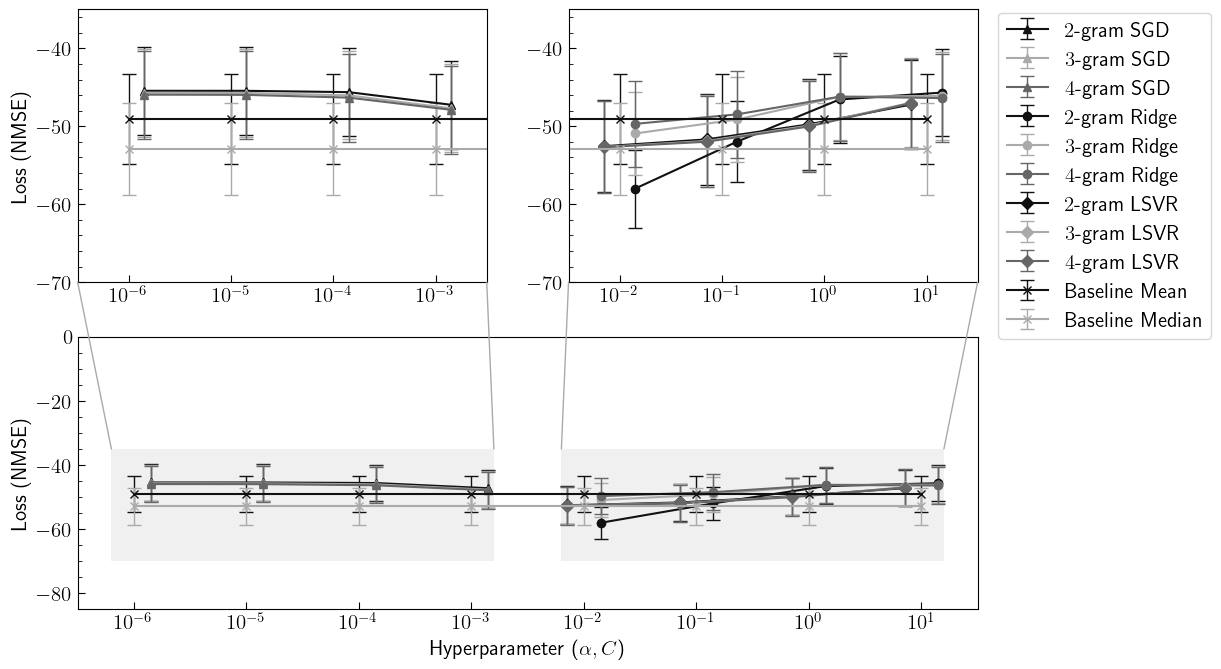

In [30]:
plot_base_hp_results(results)

## Plot Bert Hyperparameter Results

In [33]:
def load_bert_train_results(filename):
    with open(filename, 'r') as f:
        data = ast.literal_eval(f.readlines()[1])
    return data

In [39]:
def plot_bert_hp_results():
    # set up plot
    styles = (cycler('color', ['#aaa', '#111', '#666']) * cycler('marker', ['2', 'x']))
    ax = plt.gca()
    ax.set_prop_cycle(styles)
    # load and plot results
    batch_sizes = [16, 32, 64]
    num_epochs = [2, 3, 4]
    i = 0
    for batch_size in batch_sizes:
        Y1, Y2 = [], []
        for num_epoch in num_epochs:
            data = load_bert_train_results(PATH_RESULTS_HP % i)
            Y1.append(-data['loss'][-1]) # convert to NMSE
            Y2.append(-data['val_loss'][-1]) # convert to NMSE
            i += 1
        plt.plot(num_epochs, Y1, label=f'Training ($n = {batch_size}$)')
        plt.plot(num_epochs, Y2, label=f'Validation ($n = {batch_size}$)')
    # plot configuration
    plt.xticks(num_epochs)
    plt.ylim([-90, 0])
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss (NMSE)')
    # change legend order
    hs, ls = ax.get_legend_handles_labels()
    ixs = [1, 3, 5, 0, 2, 4]
    plt.legend([hs[ix] for ix in ixs], [ls[ix] for ix in ixs], loc='upper left', bbox_to_anchor=(1, 1))
    # save and show
    plt.savefig(DIR_FIGS + f'plot_hyperparams_bert.png')
    plt.show()

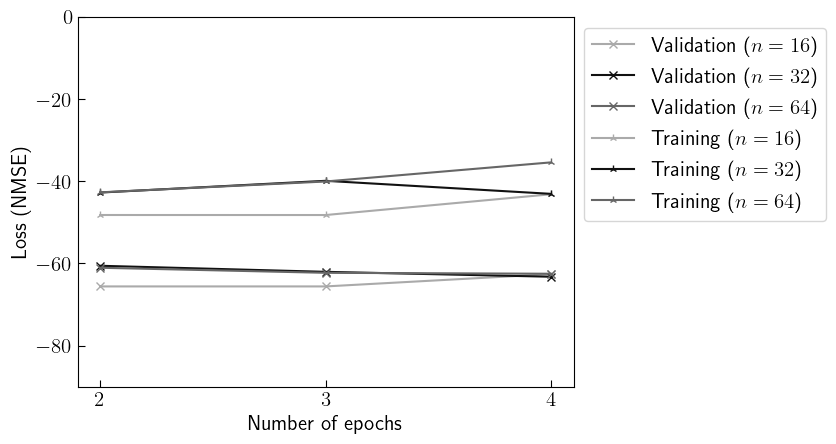

In [40]:
plot_bert_hp_results()

## Full Results

In [42]:
def load_bert_test_results(sample_name):
    path_train = PATH_RESULTS_OPT % (sample_name, 'train')
    path_test = PATH_RESULTS_OPT % (sample_name, 'test')
    with open(path_train, 'r') as f:
        data = ast.literal_eval(f.readlines()[1])
        train_loss = -data['loss'][-1] # convert to NMSE
        val_loss = -data['val_loss'][-1] # convert to NMSE
    with open(path_test, 'r') as f:
        Yt, Yp = map(ast.literal_eval, f.readlines())
    return train_loss, val_loss, Yt, Yp

In [46]:
def get_base_results_for_sample(sample_name, seed=None):
    # load sample data
    train, validation = read_data(sample_name, seed=seed)
    Xt, Yt = train['text'].tolist(), train['pt_review_scaled'].tolist()
    Xv, Yv = validation['text'].tolist(), validation['pt_review_scaled'].tolist()
    # vectorise sample data
    tfidf2 = TfidfVectorizer(ngram_range=(1, 2), binary=True, smooth_idf=False)
    Xt_tfidf2 = tfidf2.fit_transform(Xt)
    Xv_tfidf2 = tfidf2.transform(Xv)
    tfidf3 = TfidfVectorizer(ngram_range=(1, 3), binary=True, smooth_idf=False)
    Xt_tfidf3 = tfidf3.fit_transform(Xt)
    Xv_tfidf3 = tfidf3.transform(Xv)
    # init results
    results = {}
    # get results for baseline
    model_bl = DummyRegressor(strategy='mean')
    model_bl.fit(Xt, Yt)
    results['bl'] = {}
    results['bl']['mse'] = -mean_squared_error(Yv, model_bl.predict(Xv))
    results['bl']['r2'] = r2_score(Yv, model_bl.predict(Xv))
    print('>>>', 'bl_mse =', results['bl']['mse'])
    print('>>>', 'bl_r2 =', results['bl']['r2'])
    # get results for SGDRegressor
    model_sgd = SGDRegressor(penalty='l2', alpha=1e-5, max_iter=1000)
    model_sgd.fit(Xt_tfidf2, Yt)
    results['sgd'] = {}
    results['sgd']['mse'] = -mean_squared_error(Yv, model_sgd.predict(Xv_tfidf2))
    results['sgd']['r2'] = r2_score(Yv, model_sgd.predict(Xv_tfidf2))
    print('>>>', 'sgd_mse =', results['sgd']['mse'])
    print('>>>', 'sgd_r2 =', results['sgd']['r2'])
    # get results for Ridge
    model_ridge = Ridge(alpha=10)
    model_ridge.fit(Xt_tfidf2, Yt)
    results['ridge'] = {}
    results['ridge']['mse'] = -mean_squared_error(Yv, model_ridge.predict(Xv_tfidf2))
    results['ridge']['r2'] = r2_score(Yv, model_ridge.predict(Xv_tfidf2))
    print('>>>', 'ridge_mse =', results['ridge']['mse'])
    print('>>>', 'ridge_r2 =', results['ridge']['r2'])
    # get results for LinearSVR
    model_lsvr = LinearSVR(C=10, max_iter=1000)
    model_lsvr.fit(Xt_tfidf3, Yt)
    results['lsvr'] = {}
    results['lsvr']['mse'] = -mean_squared_error(Yv, model_lsvr.predict(Xv_tfidf3))
    results['lsvr']['r2'] = r2_score(Yv, model_lsvr.predict(Xv_tfidf3))
    print('>>>', 'lsvr_mse =', results['lsvr']['mse'])
    print('>>>', 'lsvr_r2 =', results['lsvr']['r2'])
    # load pre-gathered BERT results
    _, _, Yt, Yp = load_bert_test_results(sample_name)
    results['bert'] = {}
    results['bert']['mse'] = -mean_squared_error(Yt, Yp)
    results['bert']['r2'] = r2_score(Yt, Yp)
    print('>>>', 'bert_mse =', results['bert']['mse'])
    print('>>>', 'bert_r2 =', results['bert']['r2'])
    return results

In [44]:
sample_names = [
    'eng_any_any_100000', 'eng_any_long_100000', 'eng_any_short_100000',
    'any_any_any_100000', 'any_any_long_100000', 'any_any_short_100000',
]
seed = 1337
test_results = {}

In [47]:
for sample_name in sample_names:
    print(f'=== {sample_name} ===')
    test_results[sample_name] = get_base_results_for_sample(sample_name, seed=seed)

=== eng_any_any_100000 ===
>>> bl_mse = -48.09260744841022
>>> bl_r2 = -8.424263117179365e-05


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


>>> sgd_mse = -44.168068449483826
>>> sgd_r2 = 0.08152642105821295
>>> ridge_mse = -44.201747176890294
>>> ridge_r2 = 0.08082607299271838
>>> lsvr_mse = -45.76381054288451
>>> lsvr_r2 = 0.048343014967677456
>>> bert_mse = -35.286093036370026
>>> bert_r2 = 0.09220133283438814
=== eng_any_long_100000 ===
>>> bl_mse = -71.96104262956872
>>> bl_r2 = -0.00010178560377482881


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


>>> sgd_mse = -60.692546406865596
>>> sgd_r2 = 0.1565057728971092
>>> ridge_mse = -61.74770542586723
>>> ridge_r2 = 0.14184136031443417
>>> lsvr_mse = -60.71153664770054
>>> lsvr_r2 = 0.1562418499038607
>>> bert_mse = -66.03724940359643
>>> bert_r2 = 0.14095913581150699
=== eng_any_short_100000 ===
>>> bl_mse = -46.05271395587155
>>> bl_r2 = -1.155995536983312e-05


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


>>> sgd_mse = -43.05748785424804
>>> sgd_r2 = 0.0650282709039729
>>> ridge_mse = -43.05403663162227
>>> ridge_r2 = 0.06510321247039297


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


>>> lsvr_mse = -44.81508042125313
>>> lsvr_r2 = 0.026863030818862987
>>> bert_mse = -40.27376047655162
>>> bert_r2 = 0.07523339335734647
=== any_any_any_100000 ===
>>> bl_mse = -44.360856199443326
>>> bl_r2 = -0.00017049405468427814


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


>>> sgd_mse = -41.28649910753893
>>> sgd_r2 = 0.06914469764689346
>>> ridge_mse = -41.65810587706732
>>> ridge_r2 = 0.060766362373059324


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


>>> lsvr_mse = -43.3111980216072
>>> lsvr_r2 = 0.023495350752163136
>>> bert_mse = -45.577559060639665
>>> bert_r2 = 0.03595097750544651
=== any_any_long_100000 ===
>>> bl_mse = -79.9608462450089
>>> bl_r2 = -2.8801794950128468e-05


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


>>> sgd_mse = -71.32804773610621
>>> sgd_r2 = 0.10793712846224812
>>> ridge_mse = -72.26844505752948
>>> ridge_r2 = 0.096176067258962
>>> lsvr_mse = -71.20551009705379
>>> lsvr_r2 = 0.10946964311299223
>>> bert_mse = -98.74924567940461
>>> bert_r2 = 0.02486222220477563
=== any_any_short_100000 ===
>>> bl_mse = -34.7928153859514
>>> bl_r2 = -8.446143396634298e-05


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1211: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


>>> sgd_mse = -33.094977559210236
>>> sgd_r2 = 0.048718178126046396
>>> ridge_mse = -33.21895741572717
>>> ridge_r2 = 0.045154501928590274


C:\Users\Conor Mac Amhlaoibh\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


>>> lsvr_mse = -34.92938936205853
>>> lsvr_r2 = -0.004010142923833726
>>> bert_mse = -28.057470412388387
>>> bert_r2 = 0.03279800330951388


In [48]:
test_results

{'eng_any_any_100000': {'bl': {'mse': -48.09260744841022,
   'r2': -8.424263117179365e-05},
  'sgd': {'mse': -44.168068449483826, 'r2': 0.08152642105821295},
  'ridge': {'mse': -44.201747176890294, 'r2': 0.08082607299271838},
  'lsvr': {'mse': -45.76381054288451, 'r2': 0.048343014967677456},
  'bert': {'mse': -35.286093036370026, 'r2': 0.09220133283438814}},
 'eng_any_long_100000': {'bl': {'mse': -71.96104262956872,
   'r2': -0.00010178560377482881},
  'sgd': {'mse': -60.692546406865596, 'r2': 0.1565057728971092},
  'ridge': {'mse': -61.74770542586723, 'r2': 0.14184136031443417},
  'lsvr': {'mse': -60.71153664770054, 'r2': 0.1562418499038607},
  'bert': {'mse': -66.03724940359643, 'r2': 0.14095913581150699}},
 'eng_any_short_100000': {'bl': {'mse': -46.05271395587155,
   'r2': -1.155995536983312e-05},
  'sgd': {'mse': -43.05748785424804, 'r2': 0.0650282709039729},
  'ridge': {'mse': -43.05403663162227, 'r2': 0.06510321247039297},
  'lsvr': {'mse': -44.81508042125313, 'r2': 0.0268630308

## Plot Sample Scores

In [51]:
def plot_sample_scores(sample_name, results):
    keys_to_labels = {
        'bl': 'Baseline', 'sgd': 'SGD', 'ridge': 'Ridge',
        'lsvr': 'SVR', 'bert': 'BERT'
    }
    X, Y1, Y2, labels = [], [], [], []
    for i, (key, value) in enumerate(results[sample_name].items()):
        X.append(i)
        Y1.append(-value['mse'])
        Y2.append(value['r2'])
        labels.append(keys_to_labels[key])
    plt.rcParams['xtick.direction'] = 'out'
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
    plt.subplots_adjust(bottom=0, left=0, top=1, right=1, wspace=0.2)
    ax1 = init_ax(ax1, only_vertical=True)
    ax2 = init_ax(ax2, only_vertical=True)
    ax1.bar(X, Y1, color='darkgrey')
    ylim = {
        'eng_any_any_100000': [0, 60], 'eng_any_long_100000': [0, 90],
        'eng_any_short_100000': [0, 60], 'any_any_any_100000': [0, 60],
        'any_any_long_100000': [0, 110], 'any_any_short_100000': [0, 50]
    }[sample_name]
    ax1.set_ylim(ylim)
    ax1.set_xticks(X, labels)
    ax1.set_ylabel('Loss (MSE)')
    ax1.set_xlabel('Model')
    ax2.bar(X, Y2, color='darkgrey')
    ax2.set_ylim([0, 0.5])
    ax2.set_xticks(X, labels)
    ax2.set_ylabel('$R^2$ score')
    ax2.set_xlabel('Model')
    plt.savefig(DIR_FIGS + f'bars_optimal_{sample_name}.png')
    plt.show()

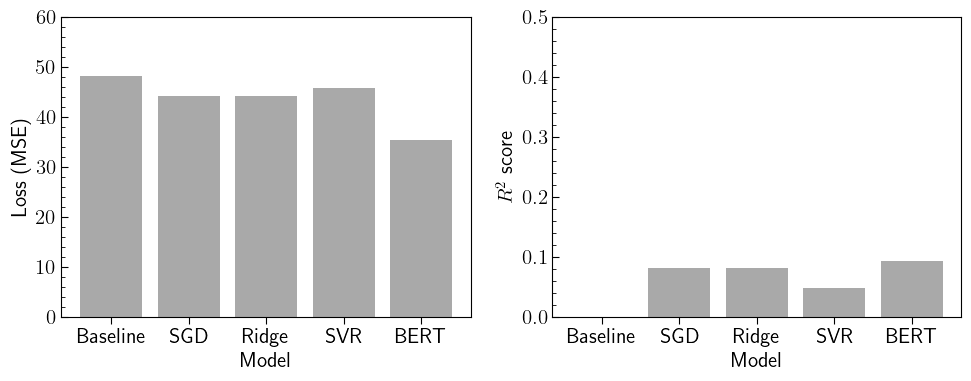

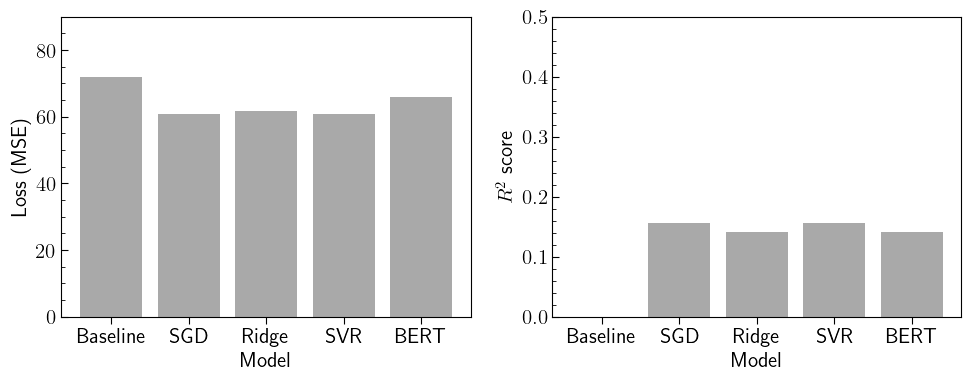

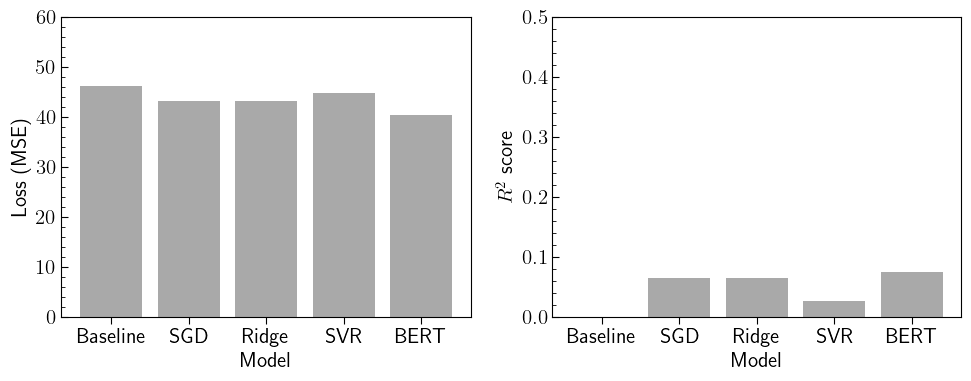

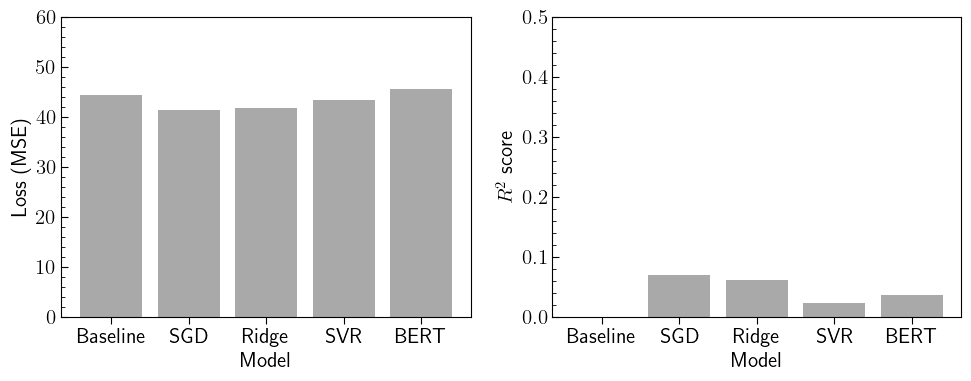

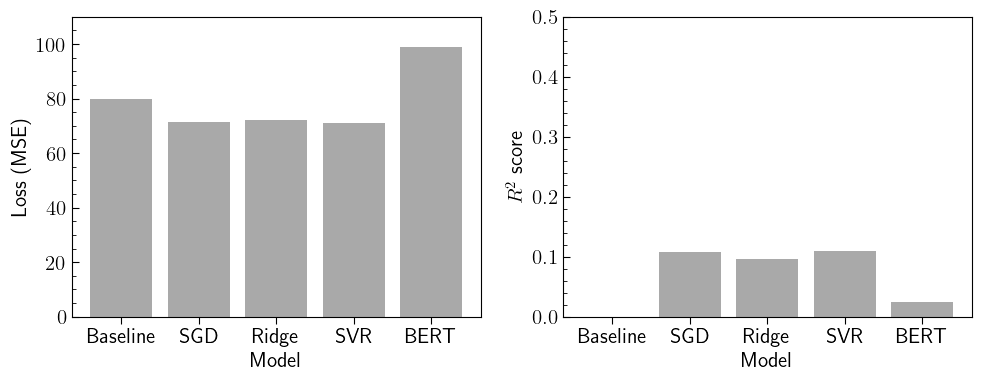

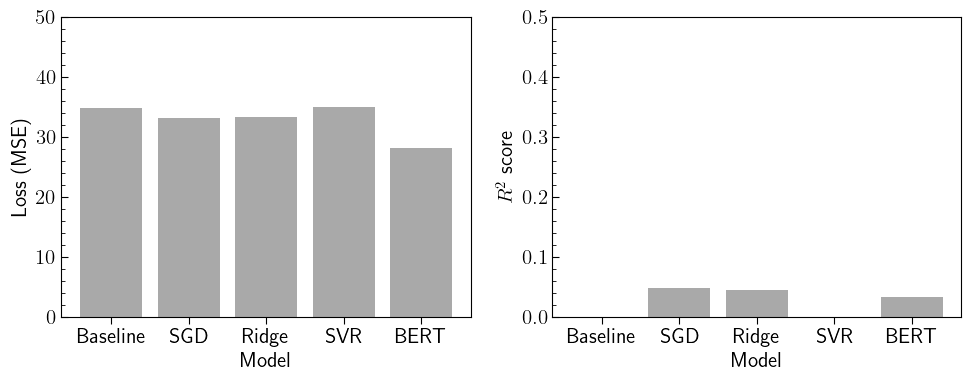

In [52]:
for sample_name in sample_names:
    plot_sample_scores(sample_name, test_results)